Circuit context


/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/gate_level/standard/q_env_config.py:104: UserWarning: No backend was provided, State vector simulation will be used
  warnings.warn("No backend was provided, State vector simulation will be used")


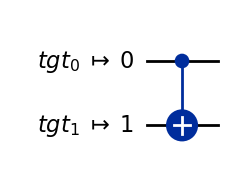

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from q_env_config import get_circuit_context, apply_parametrized_circuit, custom_instruction_durations
from rl_qoc import QuantumEnvironment, ContextAwareQuantumEnvironment
from gymnasium.wrappers import RescaleAction, ClipAction
from rl_qoc.helper_functions import get_q_env_config
import os

config_file_name = "q_env_gate_config.yml"
config_file_address = os.getcwd() + config_file_name
q_env_config = get_q_env_config(
    config_file_address,
    apply_parametrized_circuit,
)
q_env_config.parametrized_circuit_kwargs = {
    "target": q_env_config.target,
    "backend": q_env_config.backend,
}

default_num_qubits = 2
q_env_config.instruction_durations_dict = custom_instruction_durations(
    q_env_config.backend.num_qubits
    if q_env_config.backend is not None
    else default_num_qubits
)
circuit_context = get_circuit_context(
    q_env_config.backend, q_env_config.physical_qubits
)

circuit_context.draw("mpl")

In [2]:
from qiskit.visualization import plot_circuit_layout, plot_gate_map

if q_env_config.backend is not None and circuit_context.layout is not None:
    fig = plot_circuit_layout(
        circuit_context, q_env_config.backend_config.backend, view="physical"
    )
    print(
        "Selected backend:",
        q_env_config.backend.name,
        "backend version",
        q_env_config.backend_config.backend.version,
    )
elif q_env_config.backend is not None and q_env_config.backend.coupling_map.size() != 0:
    fig = plot_gate_map(q_env_config.backend)
    print(
        "Selected backend:",
        q_env_config.backend.name,
        "backend version",
        q_env_config.backend_config.backend.version,
    )
else:
    fig = None
    print("No backend selected, cannot plot circuit layout or gate map")

fig

No backend selected, cannot plot circuit layout or gate map


In [3]:
use_context = False
if use_context:
    q_env = ContextAwareQuantumEnvironment(
        q_env_config, circuit_context, training_steps_per_gate=250
    )
else:
    q_env = QuantumEnvironment(q_env_config)
rescaled_env = RescaleAction(ClipAction(q_env), -1.0, 1.0)

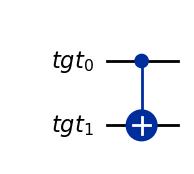

In [4]:
q_env.baseline_circuits[0].draw("mpl", style="iqp")

In [5]:
from rl_qoc.helper_functions import load_from_yaml_file
from pathlib import Path

# Change the file_name to the name of the agent configuration file and specify the file location
file_name = "agent_config.yaml"
file_location = file_name

agent_config = load_from_yaml_file(file_location)

In [6]:
from rl_qoc.ppo import CustomPPO, TrainingConfig, TrainFunctionSettings, TotalUpdates

ppo_agent = CustomPPO(agent_config, rescaled_env)
total_updates = 2000
target_fidelities = [0.9]
lookback_window = 20
anneal_learning_rate = False

ppo_config = TrainingConfig(
    TotalUpdates(total_updates),
    target_fidelities,
    lookback_window,
    anneal_learning_rate,
)
train_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=False,
    num_prints=10,
    hpo_mode=False,
    clear_history=False,
)

In [9]:
%matplotlib inline
ppo_agent.train(ppo_config, train_settings)

  6%|▌         | 116/2000 [02:07<34:55,  1.11s/it]

Starting simulation benchmark...
Starting simulation benchmark...
Fidelity stored 0.9999210721542852
Hardware runtime taken: 65.55788800000002
Sending Estimator job...


  6%|▌         | 117/2000 [02:08<34:19,  1.09s/it]

Time for running 0.918241024017334
Finished Estimator job
Starting simulation benchmark...
Starting simulation benchmark...
Fidelity stored 0.999924693716731
Hardware runtime taken: 65.88524800000002
Sending Estimator job...


  6%|▌         | 118/2000 [02:09<33:44,  1.08s/it]

Time for running 0.8992831707000732
Finished Estimator job
Starting simulation benchmark...
Starting simulation benchmark...
Fidelity stored 0.9999260082998334
Hardware runtime taken: 66.22598400000003
Sending Estimator job...


  6%|▌         | 119/2000 [02:10<36:30,  1.16s/it]

Time for running 1.2348332405090332
Finished Estimator job
Starting simulation benchmark...
Starting simulation benchmark...
Fidelity stored 0.9999280314515658
Hardware runtime taken: 66.55897600000003
Sending Estimator job...


  6%|▌         | 120/2000 [02:12<35:24,  1.13s/it]

Time for running 0.9138071537017822
Finished Estimator job
Starting simulation benchmark...
Starting simulation benchmark...
Fidelity stored 0.9999260806421397
Hardware runtime taken: 66.88070400000002
Sending Estimator job...


  6%|▌         | 121/2000 [02:13<34:44,  1.11s/it]

Time for running 0.92852783203125
Finished Estimator job
Starting simulation benchmark...
Starting simulation benchmark...
Fidelity stored 0.9999268950719934
Hardware runtime taken: 67.21651200000002
Sending Estimator job...


  6%|▌         | 121/2000 [02:13<34:36,  1.11s/it]


KeyboardInterrupt: 

In [ ]:
q_env._pubs[4][0].draw("mpl")

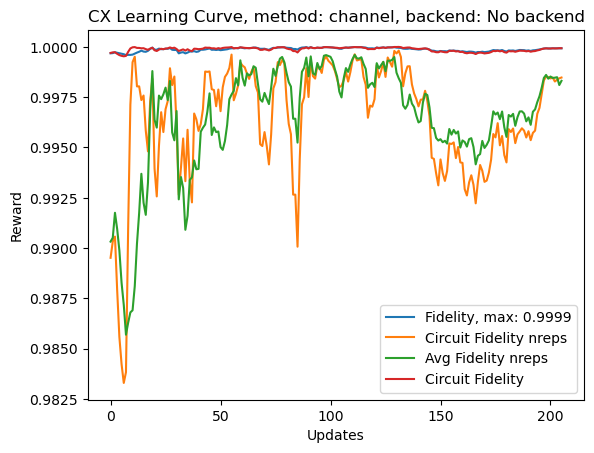

In [10]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

# plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
)
plt.plot(q_env.circuit_fidelity_history_nreps, label="Circuit Fidelity nreps")
plt.plot(q_env.avg_fidelity_history_nreps, label="Avg Fidelity nreps")
plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.legend()
plt.show()

In [ ]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
)
plt.plot(q_env.circuit_fidelity_history_nreps, label="Circuit Fidelity nreps")
plt.plot(q_env.avg_fidelity_history_nreps, label="Avg Fidelity nreps")
plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.legend()
plt.show()

In [ ]:
plt.plot(np.cumsum(q_env.total_shots), label="Number of shots")
plt.xlabel("Updates")
plt.ylabel("Shots")
plt.title(f"Shots Learning Curve, method: {q_env.config.reward_method}")
plt.legend()

In [ ]:
convergence_iteration = 60
print(
    "Number of shots required for convergence:",
    np.cumsum(q_env.total_shots[:convergence_iteration]),
)

In [ ]:
np.cumsum(q_env.hardware_runtime)

In [ ]:
from qiskit.quantum_info import average_gate_fidelity
from qiskit.quantum_info import Operator

print(
    "Fidelity of the final circuit:",
    q_env.target.gate_fidelity(
        q_env.circuits[0].assign_parameters(q_env.optimal_action).decompose()
    ),
)

In [ ]:
q_env.mean_action

In [ ]:
q_env.optimal_action

In [ ]:
from rl_qoc.helper_functions import remove_unused_wires
from qiskit.quantum_info import Operator

remove_unused_wires(
    q_env._ideal_pubs[2][0].remove_final_measurements(inplace=False)
).draw("mpl")

In [ ]:
remove_unused_wires(q_env._pubs[8][0].remove_final_measurements(inplace=False)).draw(
    "mpl"
)

In [ ]:
q_env.std_action

In [ ]:
ppo_agent.training_results["std_action"]

In [ ]:
plt.plot(ppo_agent.training_results["std_action"])

In [ ]:
plt.plot(ppo_agent.training_results["mean_action"])

In [ ]:
from qiskit import transpile
from qiskit import QuantumCircuit

qc = QuantumCircuit(1)
qc.h(0)

transpiled_qc = transpile(qc, backend=q_env_config.backend, optimization_level=0)
transpiled_qc.draw("mpl")

In [ ]:
q_env.compute_benchmarks(
    q_env.circuits[0].copy(),
    np.array(
        [np.pi * np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0])] * q_env.batch_size
    ),
)

In [ ]:
q_env._pubs[34][0].draw("mpl")

In [ ]:
q_env._pubs[33][0].draw("mpl")

In [9]:
from qiskit import pulse
from qiskit_dynamics import Signal

with pulse.build() as sched:
    pulse.play(pulse.Constant(100, 0.5), pulse.DriveChannel(0))
    pulse.shift_phase(0.5, pulse.DriveChannel(0))
    pulse.play(pulse.Gaussian(100, 0.5, 10), pulse.DriveChannel(0))
signal = Signal(sched)

TypeError: unsupported operand type(s) for *: 'ScheduleBlock' and 'float'

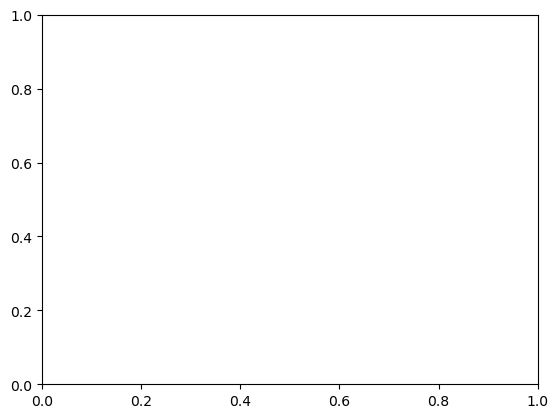

In [11]:
signal.draw(0, 100, 100)